In [550]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [888]:
df = pd.DataFrame()
df['Y'] = pd.read_csv('vars.csv')['Y']
df['Google_Index'] = pd.read_csv('vars.csv')['Google Index']
df.set_index(pd.read_csv('vars.csv')['Месяц'], inplace = True)
df = df.apply(pd.to_numeric, downcast='float', errors='coerce')

In [889]:
df.corr()

,Y,Google_Index
Y,1.000000,0.312092
Google_Index,0.312092,1.000000


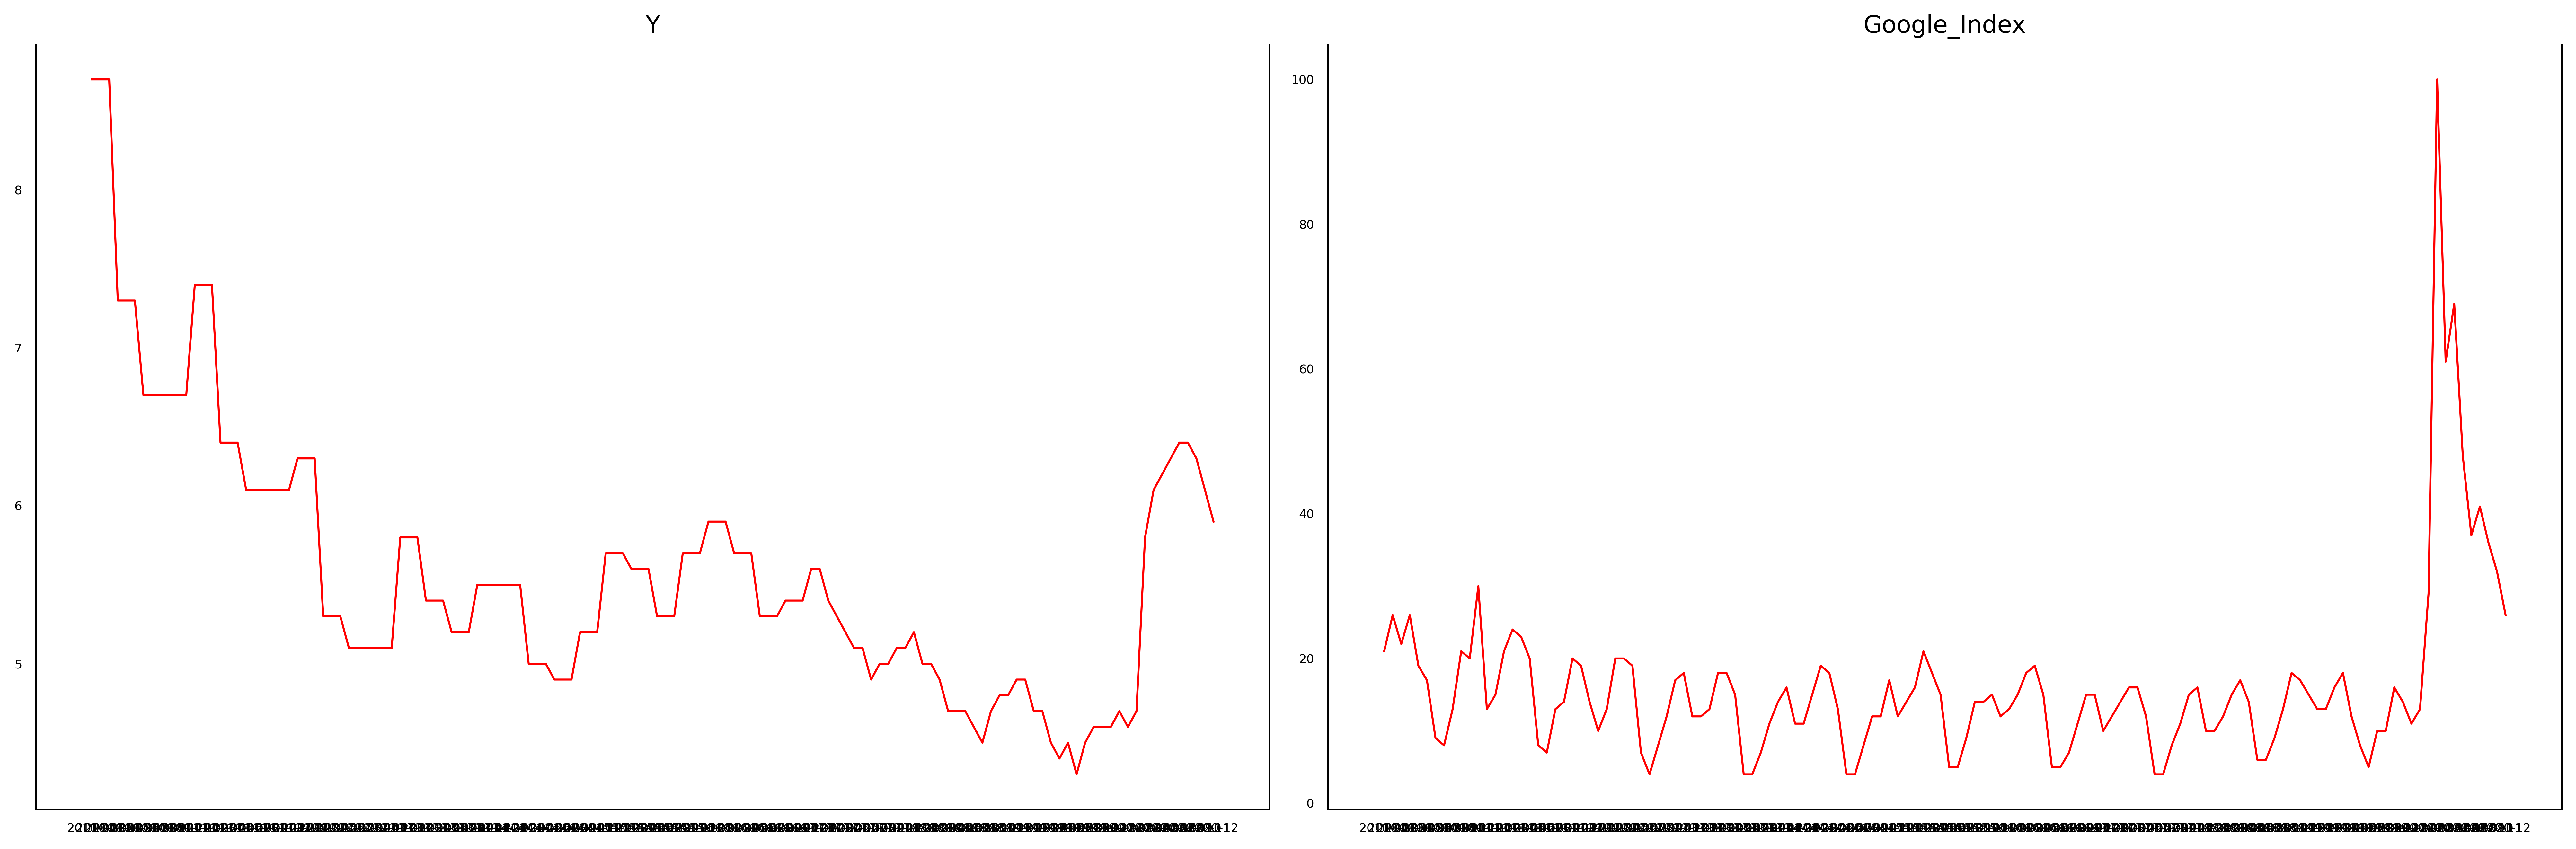

In [835]:
#Визуализация выборок

fig, axes = plt.subplots(nrows=1, ncols=2, dpi=448, figsize=(18,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [890]:
#Проверка зависимостей между временными рядами припомощи grangercasualities

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,Y_x,Google_Index_x
Y_y,1.0000,0.0
Google_Index_y,0.0263,1.0


In [837]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,1,2)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Y      ::  50.89     > 18.3985   =>   True
Google_Index ::  13.21     > 3.8415    =>   True


In [838]:
nobs = 38
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(94, 2)
(38, 2)


In [839]:
#Stationarity tests

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6243
 No. Lags Chosen       = 12
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.0881. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Google_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2162
 No. Lags Chosen       = 12
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.9366. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [845]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [846]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7364
 No. Lags Chosen       = 11
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.4124. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Google_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4653
 No. Lags Chosen       = 12
 Critical value 1%     = -3.515
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.




In [847]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [848]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.1464
 No. Lags Chosen       = 10
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Google_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.6597
 No. Lags Chosen       = 11
 Critical value 1%     = -3.515
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [891]:
model = VAR(df_differenced)
x = model.select_order(maxlags=12)
x.summary()

/Users/anr65/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,1.121,1.181,3.068,1.145
1,0.9235,1.102,2.518,0.9951
2,0.8690,1.167,2.385,0.9884
3,0.5254,0.9422,1.693,0.6925
4,0.2744,0.8103,1.318,0.4893
5,-0.4802,0.1749,0.6209,-0.2175
6,-0.6341,0.1400,0.5335,-0.3238
7,-0.8063,0.08700,0.4506,-0.4481
8,-0.9461,0.06624,0.3934,-0.5402
9,-0.9796,0.1518,0.3825,-0.5260


In [861]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Jun, 2021
Time:                     15:04:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.408598
Nobs:                     80.0000    HQIC:                  -1.30048
Log likelihood:          -101.136    FPE:                   0.156592
AIC:                     -1.89736    Det(Omega_mle):       0.0909016
--------------------------------------------------------------------
Results for equation Y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.002682         0.018044            0.149           0.882
L1.Y                    -1.113598         0.132512           -8.404           0.000
L1.Google_Index          0.005035         0.009453  

In [862]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Y      : 2.02
Google_Index : 2.16


In [863]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

12


array([[-9.9999905e-02,  0.0000000e+00],
       [ 0.0000000e+00, -4.0000000e+00],
       [ 1.9999981e-01, -5.0000000e+00],
       [-1.9999981e-01,  7.0000000e+00],
       [-1.9999981e-01,  0.0000000e+00],
       [ 9.9999905e-02,  0.0000000e+00],
       [-4.7683716e-07, -2.0000000e+00],
       [ 4.7683716e-07, -4.0000000e+00],
       [ 9.9999905e-02, -4.0000000e+00],
       [-1.9999981e-01,  8.0000000e+00],
       [ 2.9999971e-01,  4.0000000e+00],
       [-9.9999905e-02, -1.0000000e+00]], dtype=float32)

In [864]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Y_2d,Google_Index_2d
Месяц,,
2017-11,0.106975,0.552323
2017-12,-0.062315,-4.278570
2018-01,0.060748,-3.595860
2018-02,-0.066149,5.305944
2018-03,-0.227321,1.815453
2018-04,0.030385,-1.333018
2018-05,0.066425,-0.383605
2018-06,0.007545,-5.817837
2018-07,0.046890,-1.505212


In [865]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [866]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Y_forecast', 'Google_Index_forecast']]

,Y_forecast,Google_Index_forecast
Месяц,,
2017-11,5.106975,14.552323
2017-12,5.151635,13.826076
2018-01,5.257042,9.503970
2018-02,5.296301,10.487807
2018-03,5.108238,13.287099
2018-04,4.950560,14.753372
2018-05,4.859307,15.836041
2018-06,4.775600,11.100872
2018-07,4.738783,4.860492


/Users/anr65/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/anr65/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


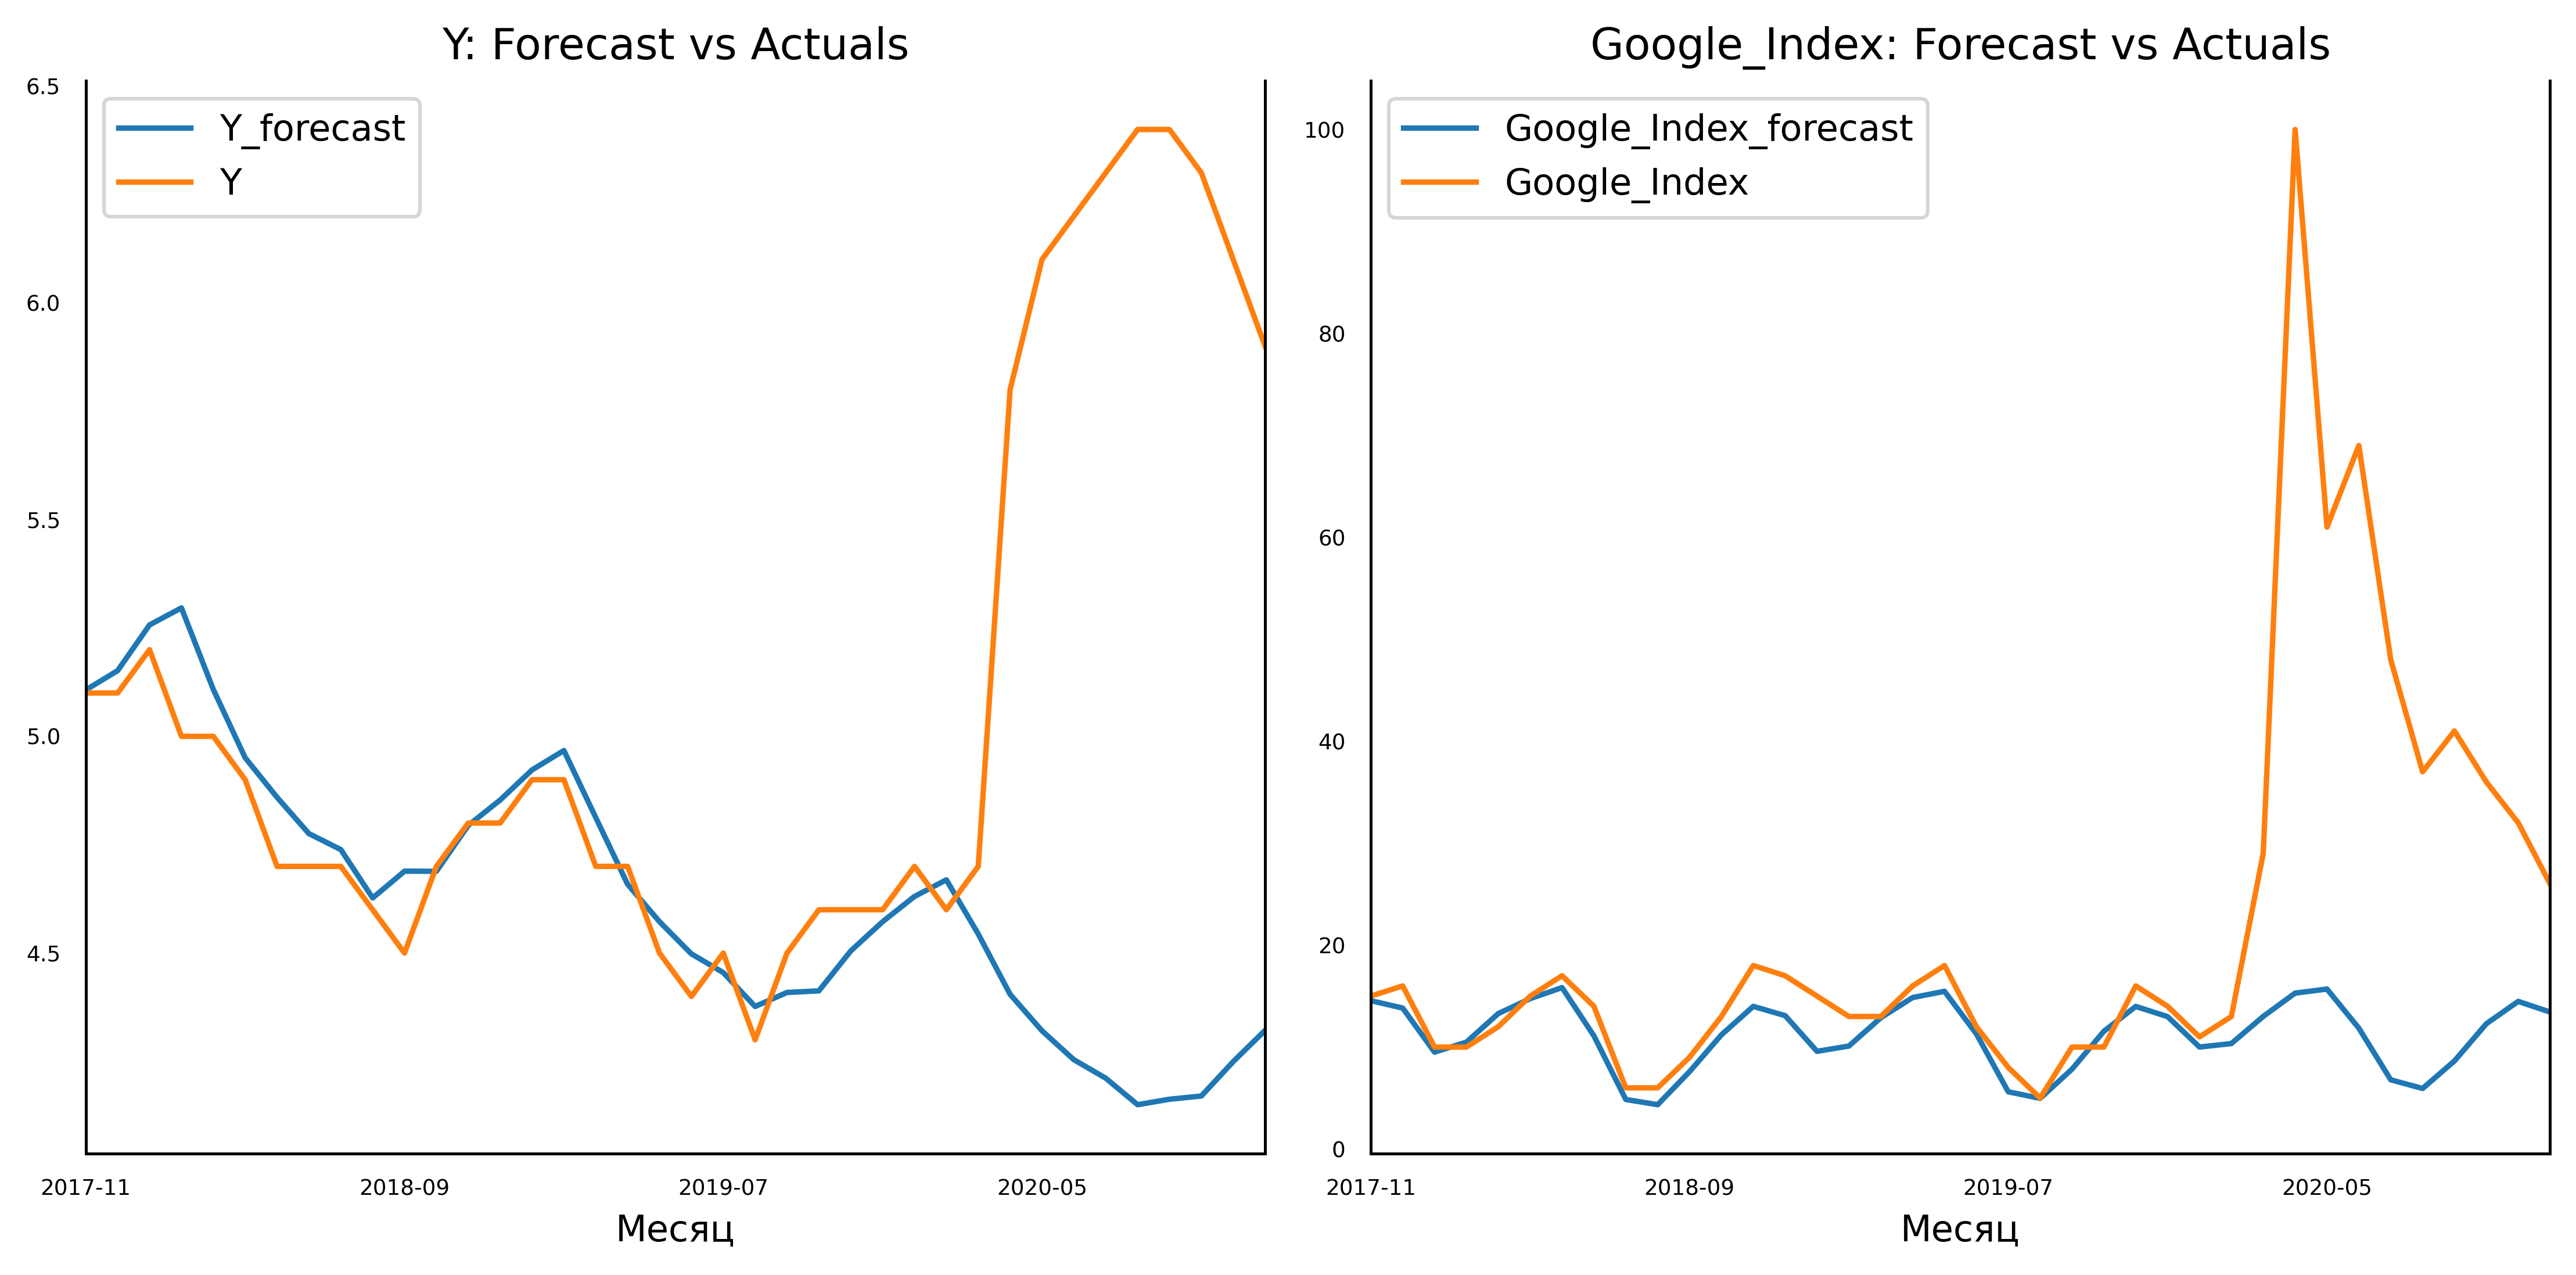

In [868]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=448, figsize=(10,5))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [876]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('\nForecast Accuracy of: Y')
accuracy_prod = forecast_accuracy(df_results['Y_forecast'].values, df_test['Y'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Google_Index')
accuracy_prod = forecast_accuracy(df_results['Google_Index_forecast'].values, df_test['Google_Index'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

#print('\nForecast Accuracy of: Реальная_ставка')
#accuracy_prod = forecast_accuracy(df_results['Реальная_ставка_forecast'].values, df_test['Реальная_ставка'])
#for k, v in accuracy_prod.items():
    #print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Y
mape   :  0.0866
mae    :  0.5162
mpe    :  -0.0684
rmse   :  0.9471
corr   :  -0.4826
minmax :  0.0863

Forecast Accuracy of: Google_Index
mape   :  0.291
mae    :  10.7982
mpe    :  -0.2746
rmse   :  21.5309
corr   :  0.2824
minmax :  0.2901


In [870]:
df['dummy'] = pd.read_csv('vars.csv')['dummy']
#df['Динамика_ВВП'] = pd.read_csv('vars.csv')['Темпы ВВП']
#df['Реальная_ставка'] = pd.read_csv('vars.csv')['Реальная ставка']
#df['Инфляция'] = pd.read_csv('vars.csv')['Инфляция']

df.loc[(df.Google_Index > 50), ('dummy')] = 1

In [875]:
#C добавлением дамми данных

df1 = pd.DataFrame()
df1['Y'] = pd.read_csv('vars.csv')['Y']
df1['Google_Index'] = pd.read_csv('vars.csv')['Google Index']
df1['dummy'] = pd.read_csv('vars.csv')['dummy']
df1.set_index(pd.read_csv('vars.csv')['Месяц'], inplace = True)
df1 = df1.apply(pd.to_numeric, downcast='float', errors='coerce')

In [879]:
nobs = 38
df1_train, df1_test = df1[0:-nobs], df1[-nobs:]

# Check size
print(df1_train.shape)
print(df1_test.shape)

(94, 3)
(38, 3)


In [882]:
df1_train.describe()

,Y,Google_Index,dummy
count,94.000000,94.000000,94.0
mean,5.798938,13.765958,0.0
std,0.831179,5.682317,0.0
min,4.900000,4.000000,0.0
25%,5.225000,10.250000,0.0
50%,5.550000,14.000000,0.0
75%,6.100000,18.000000,0.0
max,8.700000,30.000000,0.0


In [ ]:
# В столбце dummy нули, определитель матрицы будет равен нулю при попытке прогнозирования

In [930]:
df2 = pd.DataFrame()
df2['Y'] = pd.read_csv('vars.csv')['Y']
df2['Google_Index'] = pd.read_csv('vars.csv')['Google Index']
df2['Динамика_ВВП'] = pd.read_csv('vars.csv')['Темпы ВВП']
df2['Реальная_ставка'] = pd.read_csv('vars.csv')['Реальная ставка']
df2['Инфляция'] = pd.read_csv('vars.csv')['Инфляция']
df2.set_index(pd.read_csv('vars.csv')['Месяц'], inplace = True)
df2 = df2.apply(pd.to_numeric, downcast='float', errors='coerce')

In [931]:
df2.corr()

,Y,Google_Index,Динамика_ВВП,Реальная_ставка,Инфляция
Y,1.000000,0.312092,0.142093,-0.325135,0.239170
Google_Index,0.312092,1.000000,-0.511407,-0.088367,-0.148060
Динамика_ВВП,0.142093,-0.511407,1.000000,0.263345,-0.261779
Реальная_ставка,-0.325135,-0.088367,0.263345,1.000000,-0.780373
Инфляция,0.239170,-0.148060,-0.261779,-0.780373,1.000000


In [ ]:
#Визуализация выборок

fig, axes = plt.subplots(nrows=3, ncols=3, dpi=448, figsize=(18,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [932]:
#Проверка зависимостей между временными рядами припомощи grangercasualities

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df2, variables = df2.columns)

,Y_x,Google_Index_x,Динамика_ВВП_x,Реальная_ставка_x,Инфляция_x
Y_y,1.0000,0.0000,0.0067,0.0627,0.2779
Google_Index_y,0.0263,1.0000,0.0001,0.7027,0.2826
Динамика_ВВП_y,0.0529,0.0023,1.0000,0.3064,0.1612
Реальная_ставка_y,0.1388,0.2894,0.0525,1.0000,0.0001
Инфляция_y,0.2731,0.6105,0.2190,0.0101,1.0000


In [935]:
df2 = df2.drop(['Реальная_ставка'], axis=1)
df2 = df2.drop(['Инфляция'], axis=1)

KeyError: "['Реальная_ставка'] not found in axis"

In [936]:
df2

,Y,Google_Index,Динамика_ВВП
Месяц,,,
2010-01,8.7,21.0,4.07
2010-02,8.7,26.0,4.07
2010-03,8.7,22.0,4.07
2010-04,7.3,26.0,5.00
2010-05,7.3,19.0,5.00
...,...,...,...
2020-08,6.4,37.0,-3.50
2020-09,6.4,41.0,-3.50
2020-10,6.3,36.0,-1.80


In [937]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,1,2)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df2.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Y      ::  60.67     > 35.0116   =>   True
Google_Index ::  20.56     > 18.3985   =>   True
Динамика_ВВП ::  7.1       > 3.8415    =>   True


In [938]:
nobs = 38
df2_train, df2_test = df2[0:-nobs], df2[-nobs:]

# Check size
print(df2_train.shape)
print(df2_test.shape)

(94, 3)
(38, 3)


In [939]:
#Тест на стационарность

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        
for name, column in df2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6243
 No. Lags Chosen       = 12
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.0881. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Google_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2162
 No. Lags Chosen       = 12
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.9366. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Динамика_ВВП" 
    -----------------------------------------------
 Null Hypothesis: Dat

In [940]:
# 1st difference
df2_differenced = df2_train.diff().dropna()

In [941]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df2_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7364
 No. Lags Chosen       = 11
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.4124. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Google_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4653
 No. Lags Chosen       = 12
 Critical value 1%     = -3.515
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Динамика_ВВП" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

In [942]:
# Second Differencing
df2_differenced = df2_differenced.diff().dropna()

In [943]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df2_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.1464
 No. Lags Chosen       = 10
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Google_Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.6597
 No. Lags Chosen       = 11
 Critical value 1%     = -3.515
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Динамика_ВВП" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

In [944]:
model2 = VAR(df2_differenced)
x2 = model.select_order(maxlags=12)
x2.summary()

/Users/anr65/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,1.382,1.471,3.984,1.418
1,1.173,1.530,3.232,1.316
2,0.9797,1.605,2.667,1.230
3,0.6060,1.499,1.840,0.9642
4,0.4240,1.585,1.541,0.8895
5,-0.3926,1.037*,0.6865,0.1804
6,-0.4992,1.198,0.6241,0.1813
7,-0.7608,1.204,0.4881,0.02708
8,-1.081,1.152,0.3621,-0.1854
9,-1.236,1.265,0.3187,-0.2334


In [945]:
model_fitted2 = model2.fit(12)
model_fitted2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Jun, 2021
Time:                     18:17:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    1.41238
Nobs:                     80.0000    HQIC:                 -0.567591
Log likelihood:          -153.838    FPE:                   0.189235
AIC:                     -1.89269    Det(Omega_mle):       0.0604943
--------------------------------------------------------------------
Results for equation Y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.005623         0.018724            0.300           0.764
L1.Y                    -1.083684         0.148170           -7.314           0.000
L1.Google_Index          0.004275         0.010838  

In [946]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted2.resid)

def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df2.columns, out):
    print(adjust(col), ':', round(val, 2))

Y      : 2.03
Google_Index : 2.2
Динамика_ВВП : 1.91


In [947]:
# Get the lag order
lag_order2 = model_fitted2.k_ar
print(lag_order2)

# Input data for forecasting
forecast_input2 = df2_differenced.values[-lag_order2:]
forecast_input2

12


array([[-9.9999905e-02,  0.0000000e+00, -4.0000001e-01],
       [ 0.0000000e+00, -4.0000000e+00,  0.0000000e+00],
       [ 1.9999981e-01, -5.0000000e+00,  7.9999995e-01],
       [-1.9999981e-01,  7.0000000e+00, -7.9999995e-01],
       [-1.9999981e-01,  0.0000000e+00,  0.0000000e+00],
       [ 9.9999905e-02,  0.0000000e+00,  1.0000000e+00],
       [-4.7683716e-07, -2.0000000e+00, -1.0000000e+00],
       [ 4.7683716e-07, -4.0000000e+00,  0.0000000e+00],
       [ 9.9999905e-02, -4.0000000e+00,  2.9999995e-01],
       [-1.9999981e-01,  8.0000000e+00, -2.9999995e-01],
       [ 2.9999971e-01,  4.0000000e+00,  0.0000000e+00],
       [-9.9999905e-02, -1.0000000e+00, -1.5999999e+00]], dtype=float32)

In [948]:
# Прогноз
fc2 = model_fitted2.forecast(y=forecast_input2, steps=nobs)
df_forecast2 = pd.DataFrame(fc2, index=df2.index[-nobs:], columns=df2.columns + '_2d')
df_forecast2

,Y_2d,Google_Index_2d,Динамика_ВВП_2d
Месяц,,,
2017-11,0.192262,1.550036,1.698697
2017-12,-0.073200,-4.643025,-0.429936
2018-01,-0.055193,-4.107103,-0.231736
2018-02,0.077753,5.268154,0.406221
2018-03,-0.296430,0.964555,0.260221
2018-04,0.049520,-0.651364,-0.314883
2018-05,0.045865,0.334906,0.132080
2018-06,-0.049565,-5.721205,0.130729
2018-07,0.190829,-2.731426,0.096950


In [949]:
def invert_transformation(df2_train, df_forecast2, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc2 = df_forecast2.copy()
    columns = df2_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc2[str(col)+'_1d'] = (df2_train[col].iloc[-1]-df2_train[col].iloc[-2]) + df_fc2[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc2[str(col)+'_forecast'] = df2_train[col].iloc[-1] + df_fc2[str(col)+'_1d'].cumsum()
    return df_fc2

In [951]:
df2_results = invert_transformation(df2_train, df_forecast2, second_diff=True)        
df2_results.loc[:, ['Y_forecast', 'Google_Index_forecast', 'Динамика_ВВП_forecast']]

,Y_forecast,Google_Index_forecast,Динамика_ВВП_forecast
Месяц,,,
2017-11,5.192262,15.550036,1.098698
2017-12,5.311325,15.457048,0.767459
2018-01,5.375194,11.256957,0.204484
2018-02,5.516817,12.325020,0.047731
2018-03,5.362009,14.357638,0.151198
2018-04,5.256721,15.738892,-0.060218
2018-05,5.197298,17.455052,-0.139553
2018-06,5.088309,13.450007,-0.088160
2018-07,5.170150,6.713536,0.060183


/Users/anr65/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/anr65/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/anr65/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


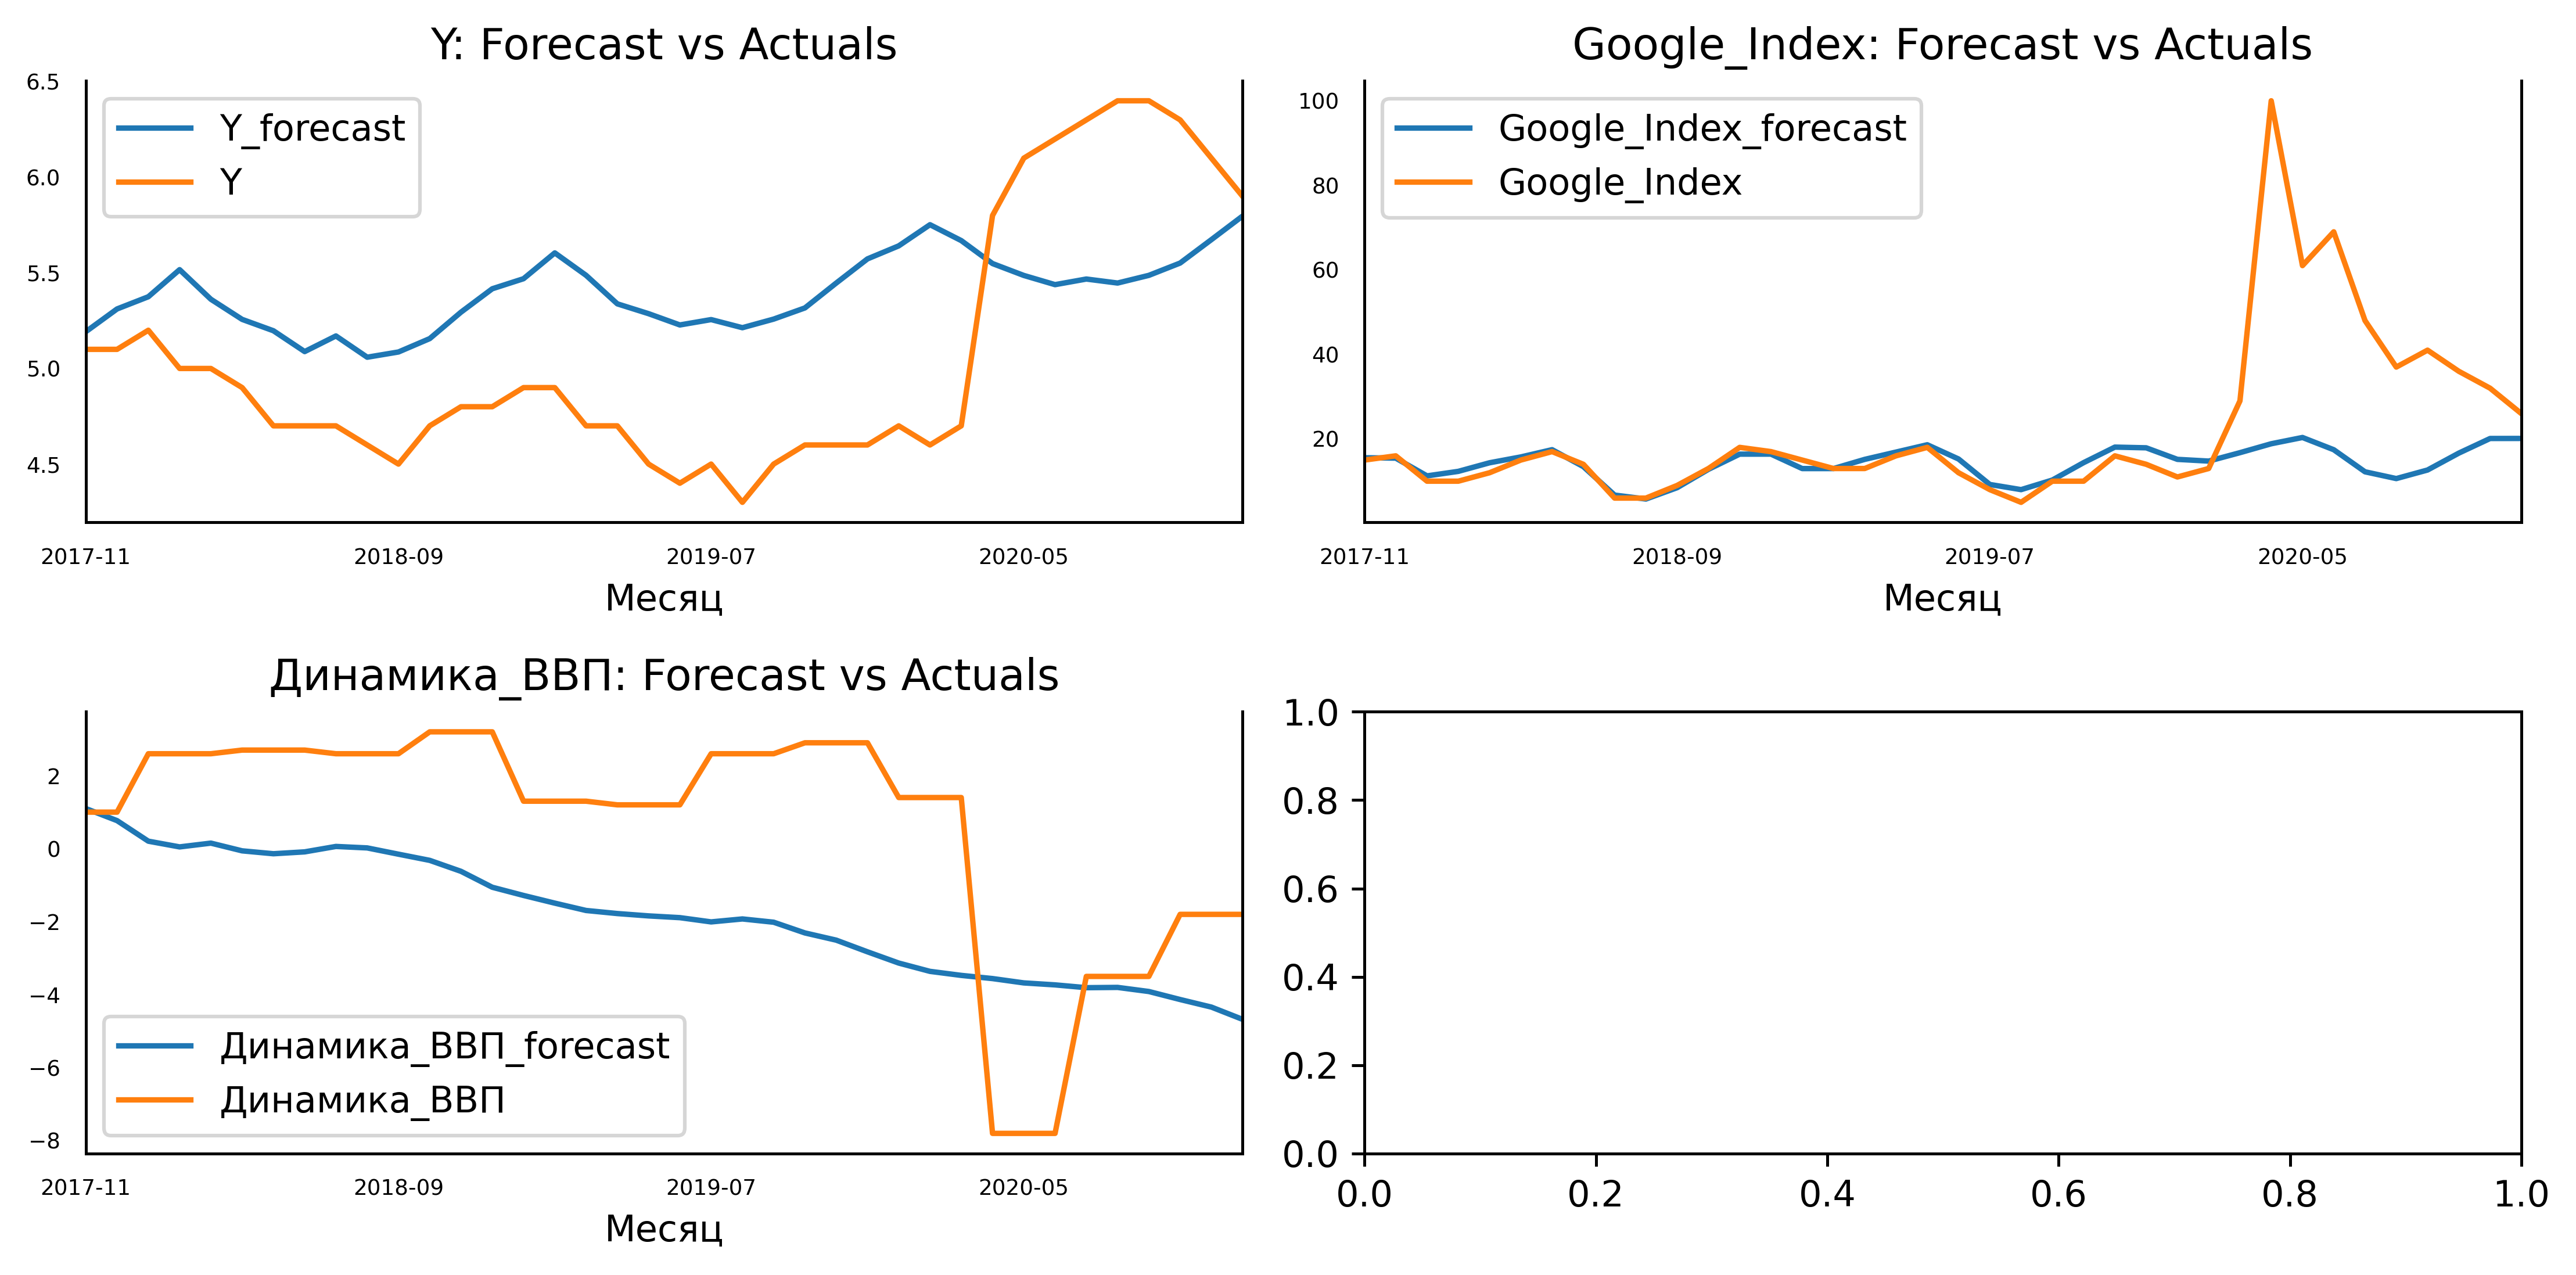

In [952]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=448, figsize=(10,5))
for i, (col,ax) in enumerate(zip(df2.columns, axes.flatten())):
    df2_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df2_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [957]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('\nForecast Accuracy of: Y')
accuracy_prod = forecast_accuracy(df2_results['Y_forecast'].values, df2_test['Y'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Google_Index')
accuracy_prod = forecast_accuracy(df2_results['Google_Index_forecast'].values, df2_test['Google_Index'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Динамика ВВП')
accuracy_prod = forecast_accuracy(df2_results['Динамика_ВВП_forecast'].values, df2_test['Динамика_ВВП'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Y
mape   :  0.1255
mae    :  0.6217
mpe    :  0.0783
rmse   :  0.6744
corr   :  0.4436
minmax :  0.1117

Forecast Accuracy of: Google_Index
mape   :  0.2587
mae    :  9.3585
mpe    :  -0.0769
rmse   :  19.5236
corr   :  0.4496
minmax :  0.2385

Forecast Accuracy of: Динамика ВВП
mape   :  1.4263
mae    :  3.1192
mpe    :  -1.1791
rmse   :  3.4407
corr   :  0.6486
minmax :  1.0526


In [962]:
df2_results['Y_forecast'].to_excel('Y_for.xlsx')

In [964]:
df2_results['Google_Index_forecast'].to_excel('GI_for.xlsx')

In [965]:
df2_results['Динамика_ВВП_forecast'].to_excel('ДВ_for.xlsx')